## Constructing a riskless yield curve for Euro
The first thing we need to do to price any option on an equity priced in Euro is construct the so-called riskless yield curve for Euro. This is because pricing of derivatives is done in _the risk-neutral world_ where all investors are assumed not to require a premium for additional risks, hence future cashflows are discounted using the riskless rate to obtain the NPV of the cashflow.

I use [the Euro area yield curve constructed daily by the ECB](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html) as proxies for riskless rates. These rates are derived from AAA-rated government bonds of the Euro area. Ideally, using swap rates might be better as government bond yields tend to be 3-4 basis points lower given that government bonds tend to be heavily used in repo trades. See the [this note from the ECB](https://www.ecb.europa.eu/pub/pdf/scpsps/ecb.sps27.en.pdf) for an explanation.

I use the following dataseries provided by the [Eurostat](https://ec.europa.eu/eurostat/web/main/data/database):
* `irt_euryld_m` &mdash; Euro yield curves (monthly frequency). This series returns a MultiIndexed dataset from which multiple yields can be extraced: Instantaneous forward yield curve, Par yield curve, and Spot rate yield curve. For pricing options I use the Spor rate yield curve. The returned rates are presented using Annual percentage rates/yields and represent the average over all business days in a given month. 
* `irt_st_m` &mdash; Euro EURIBOR rates (monthly frequency). EURIBOR uses the actual/360 daycount convention. This series returns a MultiIndexed dataset allowing to select different maturities. I only use the 1 month rates in this notebook as the spread between government bond rates and EURIBOR tends to increase with longer maturities. Rates returned represent the average over all business days in a given month.

And one dataset from [FRED](https://fred.stlouisfed.org):
* `ECBDFR` &mdash; ECB Deposit Facility Rate for Euro Area (daily frequency). I use it as proxy for overnight rate after downsampling to monthly frequency.

Ideally I'd rather use the `irt_euryld_d` dataseries from Eurostat, which provides the yield curve for the last business day. Unfortunately [pandas-datareader](https://pydata.github.io/pandas-datareader/index.html) cannot yet correctly handle this dataset. Hence I resort to the average rate over the previous month.

In the `pricing.curves.YieldCurve` class I use cubic splines by default to interpolate when constructing the curve. See [this article](http://web.math.ku.dk/~rolf/HaganWest.pdf) for more details on interpolation methods if you want to know more. Cubic splines is pretty advanced.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthBegin
from pandas.tseries.offsets import BDay

from datetime import date
import re

from dateutil.relativedelta import relativedelta

from volatility import parameter_estimators
from volatility import volatility_trackers
from pricing import curves
from pricing import options

In [2]:
today = date.today()

# Taking the last 3 months, and converting to decimal fractions
euro_curves = web.DataReader('irt_euryld_m', 'eurostat', start=(today-MonthBegin(3)).date()) / 100.
mm_rates = web.DataReader('irt_st_m', 'eurostat', start=(today-MonthBegin(3)).date()) / 100.
ecb_deposit_rate = web.get_data_fred('ECBDFR', start=today-MonthBegin(3)) / 100.

# Resample to monthly frequency
ecb_deposit_rate = ecb_deposit_rate.asfreq('D').resample('MS').mean()

In [3]:
# Making use of the MultiIndex columns to select par yields based on AAA-rate government bonds
euro_par_yields = euro_curves.sort_index(axis=1).loc[:,
                        ('Spot rate yield curve', 'AAA-rated euro area central government bonds')]

mm_rates = mm_rates.sort_index(axis=1).loc[:,
                        ('1-month rate', 'Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015)')]

# Converting EURIBOR and ECB Deposit rates from actual/360 to actual/actual
leap_year_cond = lambda idx: idx.year % 4 == 0 & ((idx.year % 100 != 0) | (idx.year % 400 == 0))
mm_rates[leap_year_cond(mm_rates.index)] *= 366. / 360
mm_rates[np.invert(leap_year_cond(mm_rates.index))] *= 365. / 360
ecb_deposit_rate[leap_year_cond(ecb_deposit_rate.index)] *= 366. / 360
ecb_deposit_rate[np.invert(leap_year_cond(ecb_deposit_rate.index))] *= 365. / 360

# Getting rid of redundant level in the MultiIndex
euro_par_yields = euro_par_yields.droplevel([1,2], axis=1)

# Converting into an integer index based on matutities in years
euro_par_yields.columns = euro_par_yields.columns.map(lambda x: int(re.search(r'(\d+)\s\w+', x)[1]))

# Rearranging columns in ascending order of maturities
euro_par_yields = euro_par_yields[euro_par_yields.columns.sort_values()]

In [4]:
date_now = euro_par_yields.index[-1].date()
offsets = list(map(lambda maturity: relativedelta(years=+maturity), euro_par_yields.columns))
monthly_offsets = [relativedelta(), relativedelta(months=+1)]
offsets = monthly_offsets + offsets

In [5]:
# Define the riskless yield curve for Euro
curve = curves.YieldCurve(today, offsets,
        np.append(
            np.append(ecb_deposit_rate.loc[str(mm_rates.index[-1])].to_numpy(), mm_rates.iloc[-1].to_numpy()),
            euro_par_yields.iloc[-1].to_numpy()),
        compounding_freq=1)

### Optional: Visualizing the riskless yield curve for Euro

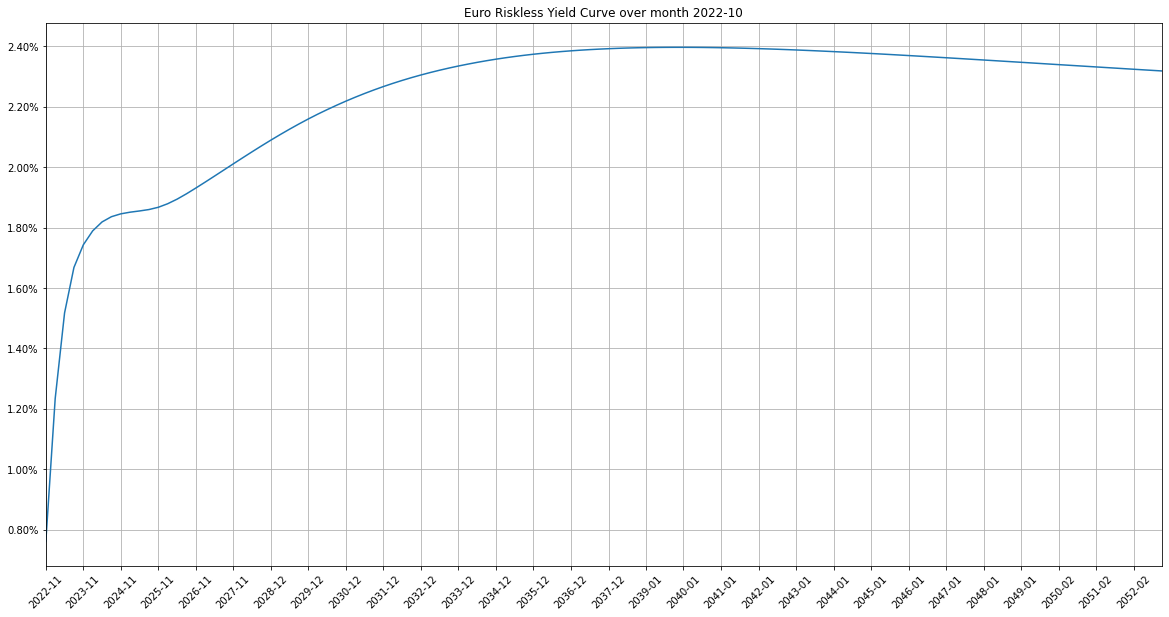

In [6]:
curve_points = curve.get_curve_points(120)
ax = curve_points.plot(figsize=(20,10), grid=True,
                       title='Euro Riskless Yield Curve over month ' + date_now.strftime('%Y-%m'),
                       xlim=(curve_points.index[0], curve_points.index[-1]),
                       xticks=curve_points.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), curve_points.index[::4])))